# Design and test a lowpass filter

This document describes how to design a lowpass filter with a cutoff frequency $\omega_c$ and compute the discrete coefficients so that it can be implemented on hardware.

In [55]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"] = 10,5
plt.rcParams["font.size"] = 16
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

## 1. Load a test signal
 
* The power spectrum is plotted as the magnitude of the discrete fourier transform (DFT): $|\hat{\boldsymbol{y}}|$

In [56]:
import pandas as pd 

# Load a signal
Ts = 0.01;
data = pd.read_csv("experimento_central_difference.csv") 
#data = pd.read_csv("experimento_Z_METHOD_STD.csv")
y = data['out_W_M1'];
t = np.arange(0,len(y)*Ts, Ts);

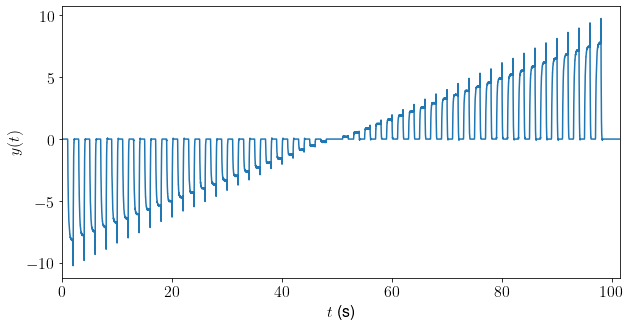

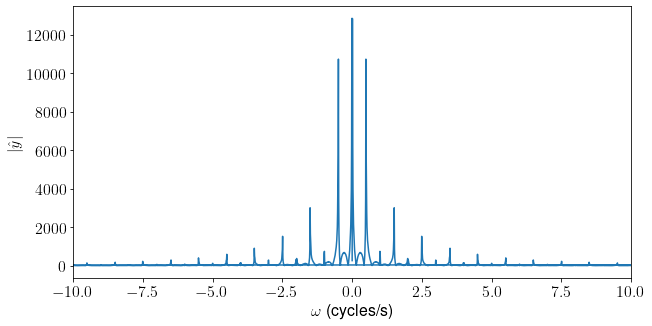

In [57]:
# Compute the Fourier transform
yhat = np.fft.fft(y);
fcycles = np.fft.fftfreq(len(t),d=Ts); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y);
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");
plt.xlim([min(t),max(t)]);

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.xlim([-10,10]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");

## 2. Low-pass filter transfer function

* A cutoff frequency is selected and the transfer function for the low-pass filter is computed using <code>signal.TransferFunction</code>
* The low-pass filter transfer function is
$$H(s) = \frac{\omega_0}{s + \omega_0}$$
* The Bode plot shows the frequency response of $H$ by plotting the magnitude and phase of the frequency response
* Low frequencies are not attenuated (this is the *pass band*)
* High frequencies are attenutated (this is the *stop band*)


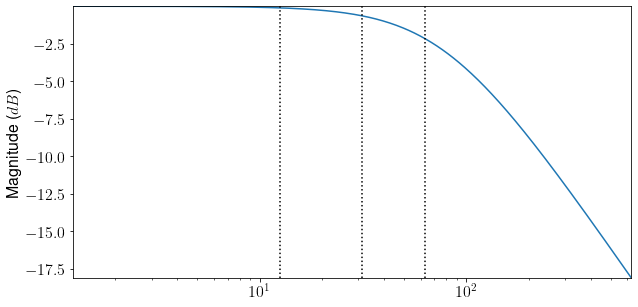

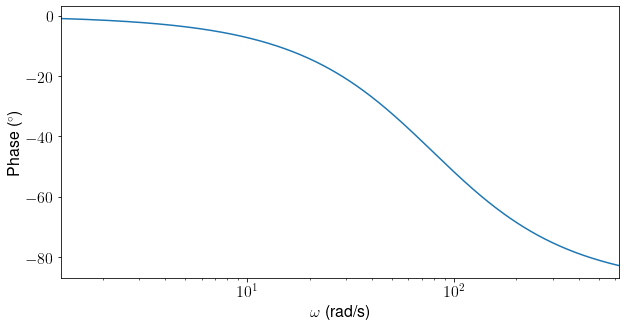

In [58]:
signalFreq = [2,5,10] # Frequency to highlight on bode plot

# Low-pass filter
w0 = 5*np.pi*5; # pole frequency (rad/s)
num = w0        # transfer function numerator coefficients
den = [1,w0]    # transfer function denominator coefficients
lowPass = signal.TransferFunction(num,den) # Transfer function

# Generate the bode plot
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()

## 3. Discrete transfer function

To implement the low-pass filter on hardware, you need to compute the discrete transfer function using the signal's sampling frequency.
* The time step is $\Delta t = 1/f_s$
* Computing the discrete transfer function using Tustin's method, set $s = \frac{2}{\Delta t} \left( \frac{1-z^{-1}}{1+z^{-1}} \right)$, so
$$ H(z) = \frac{\omega_0}{\frac{2}{\Delta t} \frac{1-z^{-1}}{1+z^{-1}}  + \omega_0} = \frac{\Delta t \omega_0 (z+1)}{(\Delta t \omega_0 + 2)z + \Delta t \omega_0 - 2} $$
* You don't have to compute it by hand. The <code>to_discrete</code> method is used to compute the bilinear transform (Tustin's method)

In [59]:
dt = Ts;
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.2819698, 0.2819698]),
array([ 1.       , -0.4360604]),
dt: 0.01
)


## 4. Filter coefficients

We want to find the filter coefficients for the discrete update:
$$y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$$

The coefficients can be taken directly from the discrete transfer function of the filter in the form:
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$$

(This is a result of taking the Z-transform which is not shown here)

Compare this to a transfer function with coefficients
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
is 
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
which is equivalent to
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$
So you can take the coefficients in the same order that they are defined in the numerator and denominator of the transfer function object. The only difference is that the **coefficients in the denominator need a negative sign**.

* To filter the signal, apply the filter using the discrete update
* The filtered signal and filtered signal power spectrum are plotted alongside the unfiltered signal

Filter coefficients b_i: [0.2819698 0.2819698]
Filter coefficients a_i: [0.4360604]


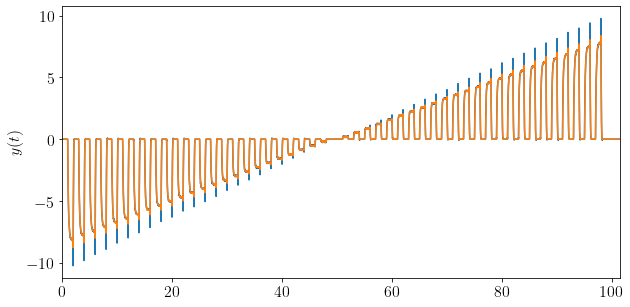

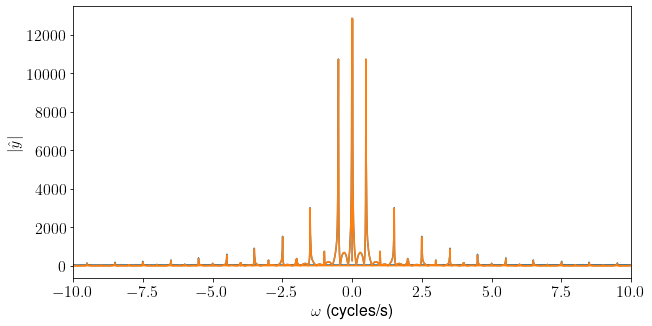

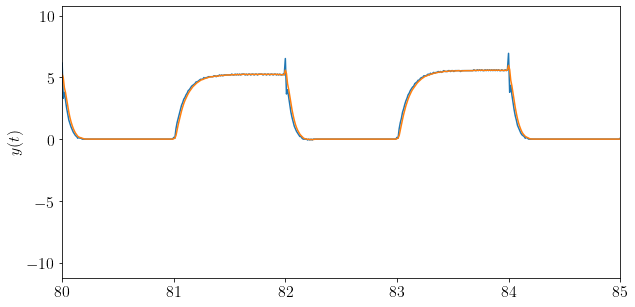

In [60]:
# The coefficients from the discrete form of the filter transfer function (but with a negative sign)
b = discreteLowPass.num;
a = -discreteLowPass.den;
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
yfilt = np.zeros(len(y));
for i in range(3,len(y)):
    yfilt[i] = a[1]*yfilt[i-1] + b[0]*y[i] + b[1]*y[i-1];
    
# Plot the signal
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)]);

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=Ts)

plt.figure()
plt.plot(fcycles,np.absolute(yhat));
plt.plot(fcycles,np.absolute(yfilthat));
plt.xlim([-10,10]);
plt.xlabel("$\omega$ (cycles/s)");
plt.ylabel("$|\hat{y}|$");


# Plot the signal - ZOOM
plt.figure()
plt.plot(t,y);
plt.plot(t,yfilt);
plt.ylabel("$y(t)$")
plt.xlim([80,85]);
